In [2]:
import numpy as np
import os
import pandas as pd
# import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from collections import OrderedDict
import joblib
import utils.models as model_utils

# Preparation

In [3]:
MODEL_FILEDIR = '/scratch/data/TrojAI/nlp-question-answering-aug2023-train/models/'
# MODEL_NUM = 117
OUTPUT_FILEDIR = '/scratch/jialin/nlp-question-answering-aug2023/extracted_features'
MODEL_SUMMARY_FILEPATH = '/scratch/data/TrojAI/nlp-question-answering-aug2023-train/METADATA.csv'
METADATA = pd.read_csv(MODEL_SUMMARY_FILEPATH)

def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

def load_model(model_num):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    # model_info_fp = model_filepath + '.stats.json'
    model = torch.load(model_filepath)
    # with open(model_info_fp, 'r') as f:
    #     model_info = json.load(f)
    return model

In [4]:
model = torch.load(os.path.join(MODEL_FILEDIR, num_to_model_id(0), 'model-state-dict.pt'))
for k, v in model.items():
    print(f'{k} - {v.shape}')

roberta.embeddings.position_ids - torch.Size([1, 514])
roberta.embeddings.word_embeddings.weight - torch.Size([50265, 768])
roberta.embeddings.position_embeddings.weight - torch.Size([514, 768])
roberta.embeddings.token_type_embeddings.weight - torch.Size([1, 768])
roberta.embeddings.LayerNorm.weight - torch.Size([768])
roberta.embeddings.LayerNorm.bias - torch.Size([768])
roberta.encoder.layer.0.attention.self.query.weight - torch.Size([768, 768])
roberta.encoder.layer.0.attention.self.query.bias - torch.Size([768])
roberta.encoder.layer.0.attention.self.key.weight - torch.Size([768, 768])
roberta.encoder.layer.0.attention.self.key.bias - torch.Size([768])
roberta.encoder.layer.0.attention.self.value.weight - torch.Size([768, 768])
roberta.encoder.layer.0.attention.self.value.bias - torch.Size([768])
roberta.encoder.layer.0.attention.output.dense.weight - torch.Size([768, 768])
roberta.encoder.layer.0.attention.output.dense.bias - torch.Size([768])
roberta.encoder.layer.0.attention.ou

In [5]:
METADATA.head()

,model_name,converged,master_seed,poisoned,model_architecture,learning_rate,cyclic_learning_rate_factor,weight_decay,batch_size,source_dataset,...,example_poisoned_f1_score,poisoned_level,model_architecture_level,learning_rate_level,cyclic_learning_rate_factor_level,weight_decay_level,batch_size_level,source_dataset_level,trigger_fraction_level,trigger_spurious_fraction_level
0,id-00000000,True,697873700,True,deepset/tinyroberta-squad2,0.00001,NaN,0.010,8,squad_v2,...,100.0,1,1,0.0,0,2,0,0,0.0,1.0
1,id-00000001,True,1400849892,False,deepset/roberta-base-squad2,0.00001,4.0,NaN,24,squad_v2,...,NaN,0,0,NaN,2,0,2,0,NaN,NaN
2,id-00000002,True,577005888,False,deepset/tinyroberta-squad2,0.00001,4.0,NaN,24,squad_v2,...,NaN,0,1,NaN,2,0,2,0,NaN,NaN
3,id-00000003,True,1364132890,True,csarron/mobilebert-uncased-squad-v2,0.00001,2.0,0.001,8,squad_v2,...,100.0,1,0,NaN,1,3,0,0,1.0,1.0
4,id-00000004,True,2056280218,True,csarron/mobilebert-uncased-squad-v2,0.00001,4.0,0.100,8,squad_v2,...,100.0,0,2,NaN,2,1,0,0,0.0,1.0


In [6]:
METADATA['model_architecture'].unique()

array(['deepset/tinyroberta-squad2', 'deepset/roberta-base-squad2',
       'csarron/mobilebert-uncased-squad-v2'], dtype=object)

### Feature Extraction

In [36]:
def _get_weight_features(model_repr, dim=(), normalize=False):
    weight_features = []
    for backbone_params in model_repr.values():
        # pshape = len(param.shape)
        # if axis is None:
            # axis = tuple(range(-1, -1*(pshape), -1))
        # weight_features += np.max(param, axis= axis, keepdims=True).flatten().tolist()
        # weight_features += np.mean(param, axis= axis, keepdims=True).flatten().tolist()
        # sub = np.mean(param, axis= axis, keepdims=True) - np.median(param, axis= axis, keepdims=True)
        # weight_features += sub.flatten().tolist()
        # weight_features += np.median(param, axis= axis, keepdims=True).flatten().tolist()
        # weight_features += np.sum(np.abs(param), axis= axis, keepdims=True).flatten().tolist()
        if normalize:
            norm = torch.linalg.norm(backbone_params.reshape(backbone_params.shape[0], -1), ord=2)
            backbone_params  = backbone_params/norm
        weight_features += torch.amax(backbone_params, dim=dim).flatten().detach().cpu().tolist()
        weight_features += torch.mean(backbone_params, dim=dim).flatten().detach().cpu().tolist()
        end_dim = -1*(len(backbone_params.shape) - len(dim)) - 1
        sub = torch.mean(backbone_params, dim=dim) - torch.median(torch.flatten(backbone_params, start_dim=0, end_dim=end_dim), dim=end_dim)[0]
        weight_features += sub.flatten().detach().cpu().tolist()
        weight_features += torch.median(torch.flatten(backbone_params, start_dim=0, end_dim=end_dim), dim=end_dim)[0].flatten().detach().cpu().tolist()
        weight_features += torch.sum(backbone_params, dim=dim).flatten().detach().cpu().tolist()
    return weight_features

def _get_eigen_features(model_repr):
    min_shape, params = 1, []
    for param in model_repr.values():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            _, singular_values, _ = np.linalg.svd(reshaped_param, False)
            ssv = np.square(singular_values).flatten()
            params.append(ssv.max().item())
            params.append(ssv.mean().item())
            params.append((ssv.mean() - np.median(ssv)).item())
            params.append(np.median(ssv).item())
            params.append(ssv.sum().item())
            # params.extend(ssv.flatten().tolist())
    return params

In [37]:
[v.shape for v in model_repr.values()]

[(50265, 768),
 (514, 768),
 (1, 768),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 768),
 (768, 3072),
 (768,),
 (768, 768),
 (768, 768),
 (768, 768),
 (768, 768),
 (768,),
 (3072, 7

In [ ]:
device = torch.device('cuda:1')

In [39]:
# X, y = [], []
X, y, X_len = {}, {}, {}
for model_num in tqdm(range(120)):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model-state-dict.pt')
    model_repr = torch.load(model_filepath)
    model_repr = OrderedDict({k:v.to(device) for k, v in model_repr.items() if k.endswith('weight')})

    feature = []
    feature += _get_weight_features(model_repr, dim=())
    # feature += _get_eigen_features(model_repr)
    
    poisoned = METADATA[METADATA['model_name'] == model_id]['poisoned'].item()
    model_class = METADATA[METADATA['model_name'] == model_id]['model_architecture'].item()

    if model_class in X:
        X[model_class].append(feature)
        y[model_class].append(poisoned)
        # X_len[model_class] = fe_len
    else:
        X[model_class] = [feature]
        y[model_class] = [poisoned]
        # X_len[model_class] = fe_len

    # X.append(feature)
    # y.append(poisoned)

    del model_repr

  0%|          | 0/120 [00:28<?, ?it/s]

In [16]:
for k, v in X.items():
    print(f'{k} - {len(v[0])}')

RobertaForQuestionAnswering - 265
MobileBertForQuestionAnswering - 2790


In [19]:
v[0]

[0.7611821293830872,
 -0.0017537472303956747,
 -3.437791019678116e-05,
 -0.0017193693201988935,
 457827.65625,
 2.8386504650115967,
 -0.0003363352734595537,
 0.0007378081791102886,
 -0.0010741434525698423,
 23559.59765625,
 1.0623023509979248,
 -0.0006699268706142902,
 0.0006345910951495171,
 -0.0013045179657638073,
 32.59471893310547,
 1.1019482612609863,
 -0.00037302522105164826,
 -0.0006681167869828641,
 0.0002950915659312159,
 21848.29296875,
 3.738607168197632,
 1.1725199222564697,
 0.18102550506591797,
 0.9914944171905518,
 600.3302001953125,
 0.9018310308456421,
 0.001646358985453844,
 0.0009801618289202452,
 0.0006661971565335989,
 1932.404541015625,
 0.67807537317276,
 0.0007071815780363977,
 0.0001390483812429011,
 0.0005681331967934966,
 1711.2860107421875,
 0.7666357755661011,
 0.00020809970737900585,
 1.81609793798998e-05,
 0.00018993872799910605,
 7002.08154296875,
 0.6548073291778564,
 0.0002456751244608313,
 0.00018852009088732302,
 5.715503357350826e-05,
 1658.08789062

In [21]:
for k, v in X.items():
    for v_ in v:
        print(len(v_))
    

265
505
265
265
505
505
265
505
505
265
505
265
265
265
265
265
505
505
265
265
265
505
265
505
505
265
505
505
265
505
505
505
505
505
265
505
265
265
505
265
265
505
265
505
505
265
505
265
265
265
505
265
505
265
505
505
265
265
505
505
505
265
265
505
265
265
505
265
505
265
265
505
505
505
505
505
265
505
265
265
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790
2790


SSD: (cen array([31,  3, 32, 37, 39, 29, 14,  0, 22, 35]), acc array([31, 37,  3, 42, 25, 39, 32, 45, 29, 19]))
DETR: (array([ 80,  55, 134,  52, 285, 321, 267, 320, 299, 305]), array([ 80,  55,  46,  52, 113, 320, 305, 134, 290, 215]))
RCNN: (array([147,  12,  18, 164, 161, 169, 114,  72,  45,  53]), array([164, 169, 161, 147,  12,  18, 114, 127, 137, 140]))

In [14]:
OUTPUT_FILEDIR = '/scratch/jialin/nlp-question-answering-aug2023/extracted_features'

In [15]:
for k, v in X.items():
    np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_X_more.npy'), v)
    np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_y_more.npy'), y[k])
    # np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_X_len.npy'), X_len[k])
    print(k, len(v[0]))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (80,) + inhomogeneous part.

In [22]:
X_len = {}
for model_num in tqdm([0, 1, 3]):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model, _, model_class = model_utils.load_model(model_filepath)
    model = model.to(device)
    if 'Detr' not in model_class:
        model_backbone = model.backbone
    else:
        model_backbone = model

    fe_len, idx_list = [], [(0, 1e8)]
    # if 'SSD' in model_class:
        # idx_list = [(2, 5)]
    # elif 'RCNN' in model_class:
        # idx_list = [(2, 3)]
    # else:
        # idx_list = [(45, 45), (69, 69), (79, 79), (89, 89)]
            
    for idx_lo, idx_hi in idx_list:
        fe_len = _get_eigen_vals(model_backbone, idx_lo, idx_hi)[1]
    X_len[model_class] = fe_len

100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


In [30]:
key = 'FasterRCNN'

In [31]:
weight_range = [0] + X_len[key]
# weight_range = list(range(0, len(X[key][0])+1, 8))

In [32]:
cens, accs = [], []
clf = GradientBoostingClassifier(learning_rate=0.015, n_estimators=900, max_depth=3, max_features= 120, min_samples_leaf= 6, min_samples_split= 24)

# Visualization

In [15]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, ret_fe_rank = False):
    all_cross_entropy, all_accuracy = [], []
    if ret_fe_rank:
        all_fe_importance = []
    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        # clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), labels=[0, 1]))
        all_accuracy.append(clf.score(X_test, y_test))
        if ret_fe_rank:
            all_fe_importance.append(clf.feature_importances_)
    if ret_fe_rank:
        return all_cross_entropy, all_accuracy, all_fe_importance
    return all_cross_entropy, all_accuracy

In [16]:
clf = GradientBoostingClassifier(n_estimators=1100, learning_rate=0.00225, max_depth=8, min_samples_split=17, subsample=.66, min_samples_leaf=4, max_features=230)

In [5]:
X, y = {}, {}
for model_class in ['BasicFCModel', 'SimplifiedRLStarter']:
    X[model_class] = np.load(os.path.join(OUTPUT_FILEDIR, f'{model_class}_X.npy'))
    y[model_class] = np.load(os.path.join(OUTPUT_FILEDIR, f'{model_class}_y.npy'))

In [6]:
fe_inds = json.load(open('/scratch/jialin/rl-lavaworld-jul2023/extracted_features/fe_ind2.json', 'r'))

In [17]:
fe_importance = {}
for k, v in X.items():
    cen, acc, fe_rank = bootstrap_performance(v, y[k], clf, n=50, test_size=.2, ret_fe_rank=True)
    print(k, np.mean(cen), np.mean(acc))
    fe_importance[k] = fe_rank
    # print(np.argsort(cen)[:10], np.asarray(cen)[np.argsort(cen)[:10]])
    # print(np.argsort(acc)[::-1][:10], np.asarray(acc)[np.argsort(acc)[::-1][:10]])

BasicFCModel 0.07416443662587176 0.9941463414634145
SimplifiedRLStarter 0.07242138362473735 0.9936363636363638


In [18]:
for k, v in X.items():
    # v_ind = v[:, fe_inds[k]]
    # print(v_ind.shape)
    joblib.dump(clf.fit(v, y[k]), os.path.join(OUTPUT_FILEDIR, f'{k}_clf3.joblib'))

BasicFCModel 0.1160307642356217 0.9683333333333334
SimplifiedRLStarter 0.11422876380716901 0.9758333333333333

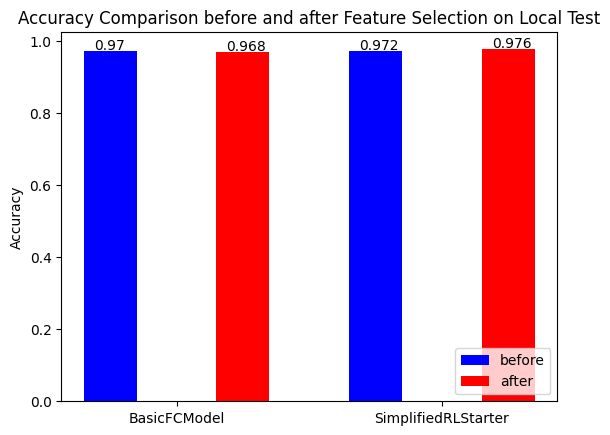

In [36]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
# ax2 = ax1.twinx() 
ax1.bar([0, 2],  [.97, .9717], width=.4, color='blue', label='before');
# ax1.bar([1, 3], [.1160, .1142], width=.4, color='green', label='after');
ax1.bar([1, 3], [0.9683, 0.9758], width=.4, color='red', label='after');
ax1.set_ylabel('Accuracy', color='black');
# ax1.tick_params(axis='y', labelcolor='orange');
# ax2.set_ylabel('Accuracy', color='b');
# ax2.tick_params(axis='y', labelcolor='b');
# ax1.set_xticks([0, 2], ['BasicFCModel', 'SimplifiedRLStarter'], rotation=5);
ax1.set_xticks([.5, 2.5], ['BasicFCModel', 'SimplifiedRLStarter']);
for ind, val in zip(range(4), [.97, 0.9683, .9717, 0.9758]):
    ax = ax1 #if ind % 2 == 0 else ax2
    h_add = .005 #if ind % 2 == 0 else .005
    ax.text(ind-.125, val+h_add, s=str(round(val, 3)))
plt.title('Accuracy Comparison before and after Feature Selection on Local Test');
plt.legend(loc=4)
plt.savefig('./extracted_features/acc_comparison.png', dpi=300)

In [39]:
fe_importance['SimplifiedRLStarter'][0].shape

(3765,)

In [26]:
fe_importance['BasicFCModel'][0][1463]

0.0

In [23]:
imp = fe_importance['BasicFCModel'][0]

np.sum(imp[np.argsort(imp)[::-1][:800]])

0.9992460058629061

In [11]:
np.nonzero(fe_importance['BasicFCModel'][0])

(array([   0,    1,    3, ..., 2346, 2348, 2349]),)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.asarray(fe_importance['BasicFCModel'][0])[np.nonzero(fe_importance['BasicFCModel'][0])[0]], bins=100)

In [14]:
importance_level = np.argsort(fe_importance['BasicFCModel'][0])[::-1][:np.count_nonzero(fe_importance['BasicFCModel'][0])]

In [15]:
np.asarray(fe_importance['BasicFCModel'][0])[importance_level]

array([9.43464973e-02, 7.12541787e-02, 6.02651122e-02, ...,
       2.85341630e-10, 1.57271242e-10, 1.38377875e-19])

In [35]:
np.nonzero(fe_importance['BasicFCModel'][0])[0]

array([   0,    1,    2, ..., 2346, 2348, 2349])

In [50]:
fe_imp_ind = {'BasicFCModel':2200, 'SimplifiedRLStarter':3200}

In [51]:
fe_importance_set = {}
for k, vs in fe_importance.items():
    imp = set(np.argsort(vs[0])[::-1][:fe_imp_ind[k]])
    for v in vs:
        valid_inds = np.argsort(v)[::-1][:fe_imp_ind[k]]
        imp = imp.intersection(valid_inds)
    fe_importance_set[k] = imp

In [52]:
for k, v in fe_importance_set.items():
    print(f'{k} - {len(v)}')

BasicFCModel - 795
SimplifiedRLStarter - 1081


In [40]:
for k, v in fe_importance_set.items():
    fe_importance_set[k] = list(v)

In [41]:
X_fe_reduced = {}
for k, v in X.items():
    X_fe_reduced[k] = np.asarray(v)[:, fe_importance_set[k]]
    print(X_fe_reduced[k].shape)

(118, 1878)
(120, 2466)


In [53]:
for k, v in fe_importance_set.items():
    fe_importance_set[k] = [int(l) for l in list(v)]

In [54]:
X_fe_reduced = {}
for k, v in X.items():
    X_fe_reduced[k] = np.asarray(v)[:, fe_importance_set[k]]
    print(X_fe_reduced[k].shape)

(118, 795)
(120, 1081)


In [58]:
import json
json.dump(fe_importance_set, open(os.path.join(OUTPUT_FILEDIR, 'fe_ind2.json'), 'w'))

In [57]:
for k, v in X_fe_reduced.items():
    cen, acc = bootstrap_performance(v, y[k], clf, n=50, test_size=.2)
    print(k, np.mean(cen), np.mean(acc))
    # fe_importance[k] = fe_rank

BasicFCModel 0.11665780598913689 0.9641666666666667
SimplifiedRLStarter 0.10297708796412654 0.9791666666666665


In [10]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.111, max_depth=2, min_samples_leaf=6, min_samples_split=16, subsample=.6, max_features=300)
# param={'max_depth': range(2, 9, 2), 'min_samples_leaf': range(2, 35, 4), 'min_samples_split': range(16, 65, 4), 'max_features': range(200, 411, 20), 'subsample': np.arange(.6, .91, .02)}
# param = {'learning_rate':np.arange(.05, .301, .05), 'n_estimators':range(100, 2001, 25)}
param = {'learning_rate':np.arange(.001, .301, .001), 'n_estimators':range(100, 3001, 25)}
# param = {'learning_rate':[.015, .03, .005, .01, .0025, .025, .003, .0015, .0005], 'n_estimators':[125, 63, 375, 187, 750, 75, 630, 1250, 3750]}
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(X, y);

In [11]:
gsearch_result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_neg_log_loss', 'rank_test_accuracy'])
gsearch_result.to_csv(os.path.join(OUTPUT_FILEDIR, f'gsearch_result_{k}.csv'))

In [12]:
gsearch_result.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,...,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
3745,0.078553,0.000611,0.001505,0.000028,0.033,125,"{'learning_rate': 0.033, 'n_estimators': 125}",-0.341112,-0.549322,-0.706908,...,0.140328,1,0.888889,0.777778,0.444444,0.750,0.250,0.622222,0.237398,32209
8073,0.063099,0.001126,0.001582,0.000049,0.07,100,"{'learning_rate': 0.07, 'n_estimators': 100}",-0.356271,-0.657309,-0.693475,...,0.131424,2,0.888889,0.666667,0.666667,0.750,0.250,0.644444,0.213293,27848
12870,0.071993,0.008178,0.001946,0.000462,0.111,100,"{'learning_rate': 0.111, 'n_estimators': 100}",-0.228063,-0.557090,-0.718041,...,0.212997,3,0.888889,0.666667,0.666667,0.750,0.625,0.719444,0.093953,2464
5850,0.062990,0.000678,0.001561,0.000037,0.051,100,"{'learning_rate': 0.051000000000000004, 'n_est...",-0.352012,-0.573338,-0.721012,...,0.142894,4,0.888889,0.777778,0.666667,0.625,0.375,0.666667,0.172357,20042
5968,0.079375,0.001292,0.001526,0.000033,0.052,125,"{'learning_rate': 0.052000000000000005, 'n_est...",-0.273112,-0.569925,-0.681151,...,0.193816,5,0.888889,0.666667,0.666667,0.750,0.250,0.644444,0.213293,27848
7839,0.063560,0.001277,0.001533,0.000042,0.068,100,"{'learning_rate': 0.068, 'n_estimators': 100}",-0.273675,-0.567905,-0.705889,...,0.190345,6,1.000000,0.666667,0.666667,0.750,0.375,0.691667,0.200000,9553
3042,0.062784,0.000799,0.001521,0.000027,0.027,100,"{'learning_rate': 0.027000000000000003, 'n_est...",-0.462242,-0.584624,-0.601283,...,0.103198,7,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042
3393,0.062645,0.000817,0.001481,0.000028,0.03,100,"{'learning_rate': 0.030000000000000002, 'n_est...",-0.405477,-0.606294,-0.640579,...,0.122382,8,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042
4565,0.094876,0.001898,0.001575,0.000037,0.04,150,"{'learning_rate': 0.04, 'n_estimators': 150}",-0.285554,-0.617364,-0.692358,...,0.186864,9,1.000000,0.555556,0.666667,0.750,0.375,0.669444,0.207573,19652
1291,0.125181,0.002050,0.001607,0.000009,0.012,200,"{'learning_rate': 0.012, 'n_estimators': 200}",-0.468924,-0.609551,-0.642298,...,0.088974,10,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042


In [13]:
gsearch_result['mean_test_accuracy']

3745     0.622222
8073     0.644444
12870    0.719444
5850     0.666667
5968     0.644444
           ...   
29586    0.619444
33249    0.650000
34539    0.700000
34500    0.630556
34179    0.652778
Name: mean_test_accuracy, Length: 35100, dtype: float64

In [14]:
gsearch_result['rank_test_accuracy']

3745     32209
8073     27848
12870     2464
5850     20042
5968     27848
         ...  
29586    32524
33249    24445
34539     3014
34500    28522
34179    21022
Name: rank_test_accuracy, Length: 35100, dtype: int32

In [15]:
gsearch_result['mean_test_neg_log_loss']

3745    -0.596133
8073    -0.608179
12870   -0.611247
5850    -0.614984
5968    -0.619903
           ...   
29586   -3.528528
33249   -3.534978
34539   -3.559429
34500   -3.560073
34179   -3.623068
Name: mean_test_neg_log_loss, Length: 35100, dtype: float64